In [1]:
# Download data (same as from Kaggle)
#!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# # Unzip the downloaded file - will have train.csv and test.csv files
import zipfile
zip_ref = zipfile.ZipFile("nlp_getting_started.zip", "r")  
zip_ref.extractall()
zip_ref.close()
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
#!pip install tensorflow_hub

In [3]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
print(train_df_shuffled.head(2))
# How many examples of each class?
print("\n",train_df.target.value_counts())
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

        id      keyword location  \
2644  3796  destruction      NaN   
2227  3185       deluge      NaN   

                                                   text  target  
2644  So you have a new weapon that can cause un-ima...       1  
2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  

 0    4342
1    3271
Name: target, dtype: int64
Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [4]:
# Since the test set has no labels and we need a way to evalaute our trained models, we'll split off some of the training data and create a validation set.
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [5]:
# View the first few training sentences and their labels
train_sentences[:2], train_labels[:2]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma'], dtype=object),
 array([0, 0], dtype=int64))

In [94]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

tf.keras.backend.clear_session()

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")
# Create model using the Sequential API
model = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  Dense(64, activation="relu"),
  Dropout(rate=0.5),
  Dense(32, activation="relu"),
  Dropout(rate=0.5),
  Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.02),
                metrics=["accuracy"])


filepath='./my_nlp_model.h5'
modelcheckpoint = ModelCheckpoint(filepath=filepath, save_best_only=True)


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=5, 
                              min_delta=0.01,
                              mode='min',
                              min_lr=0.0001)

earlystopping = EarlyStopping(monitor='val_accuracy',
                             min_delta=0.0001,
                             patience=10)

callbacks = [modelcheckpoint,reduce_lr,earlystopping]

#model.summary()

In [95]:
# Train a classifier on top of pretrained embeddings
history = model.fit(train_sentences,
                    train_labels,
                    epochs=50,
                    validation_data=(val_sentences, val_labels), callbacks=callbacks)

Epoch 1/50
215/215 [==============================] - 6s 18ms/step - loss: 0.5036 - accuracy: 0.7762 - val_loss: 0.4616 - val_accuracy: 0.8058 - lr: 0.0200
Epoch 2/50
215/215 [==============================] - 4s 17ms/step - loss: 0.4591 - accuracy: 0.8050 - val_loss: 0.4406 - val_accuracy: 0.8176 - lr: 0.0200
Epoch 3/50
215/215 [==============================] - 4s 17ms/step - loss: 0.4378 - accuracy: 0.8130 - val_loss: 0.4299 - val_accuracy: 0.8176 - lr: 0.0200
Epoch 4/50
215/215 [==============================] - 2s 9ms/step - loss: 0.4243 - accuracy: 0.8205 - val_loss: 0.4404 - val_accuracy: 0.8084 - lr: 0.0200
Epoch 5/50
215/215 [==============================] - 2s 8ms/step - loss: 0.4051 - accuracy: 0.8248 - val_loss: 0.4330 - val_accuracy: 0.8071 - lr: 0.0200
Epoch 6/50
215/215 [==============================] - 2s 9ms/step - loss: 0.3960 - accuracy: 0.8279 - val_loss: 0.4427 - val_accuracy: 0.8228 - lr: 0.0200
Epoch 7/50
215/215 [==============================] - 2s 8ms/step -

<AxesSubplot:>

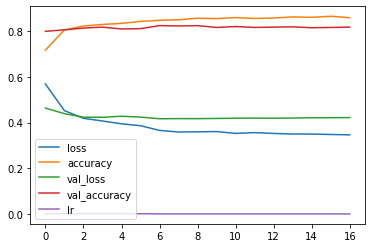

In [8]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [9]:
bestmodel = tf.keras.models.load_model((filepath),custom_objects={'KerasLayer':hub.KerasLayer})
newpred = bestmodel.predict(val_sentences)

In [10]:
# Make predictions with USE TF Hub model
model_6_pred_probs = bestmodel.predict(val_sentences)
model_6_pred_probs[21:31]

array([[0.13850689],
       [0.35915166],
       [0.01936963],
       [0.8785312 ],
       [0.98434377],
       [0.03626835],
       [0.12538087],
       [0.17400765],
       [0.20732903],
       [0.51302224]], dtype=float32)

In [11]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[21:31]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 1., 1., 0., 0., 0., 0., 1.], dtype=float32)>

In [12]:
val_labels[21:31], val_sentences[21:31]

(array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1], dtype=int64),
 array(['So I pick myself off the ground and swam before I drowned. Hit the bottom so hard I bounced twice suffice this time around is different.',
        "US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability",
        "Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube",
        "New warning for Central Hills 1' hail 60 mph winds. NOT affecting Sturgis but could later tonight. #KOTAWeather http://t.co/qo3VWFelkp",
        '70 Years After Atomic Bombs Japan Still Struggles With War Past: The anniversary of the devastation wrought b... http://t.co/iTBJ6DKRZI',
        "If I survive I'll see you tomorrow",
        'Bit pacquiao vs marquez 3 unfilled blazing swarm online: DuRvOd http://t.co/6VJA8R4YXA',
        '@SeanPeconi @Jason_Floyd @LynchOnSports @criscyborg I think the risk of losing and getting her nose flattened has 

### Other Options

In [14]:
# Find average number of tokens (words) in training Tweets
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length

15

In [21]:
# Setup text vectorization with custom variables
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,                                    
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    output_mode="int",
                                    output_sequence_length=max_length)
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [35]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street! how do i escape? this is crazy"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3,  232,    4,   13,  698,   62,   68,    8, 1084,   19,
           9,  858,    0,    0]], dtype=int64)>

In [32]:
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab)

10000

In [34]:
tf.random.set_seed(42)
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length, # set input shape
                      output_dim=128, # set size of embedding vector
                      embeddings_initializer="uniform", # default, intialize randomly
                      input_length=max_length, # how long is each input
                      name="embedding_1") 

embedding

In [55]:
# Embed the random sentence (turn it into numerical representation)
import numpy as np
sample_sentence = ["There's a flood in my street!", "how do i escape? this is crazy"]
sample_embed = embedding(text_vectorizer(sample_sentence))
#sample_embed, sample_embed.shape, sample_embed[0][0]

In [45]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

### Simple Dense

In [68]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs)            # turn the input text into numbers
x = embedding(x)                       # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding to make it compatible with the next layer
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [66]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 dense_4 (Dense)             (None, 15, 1)             129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 4s 15ms/step - loss: 0.5220 - accuracy: 0.8228 - val_loss: 0.4964 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3405 - accuracy: 0.8895 - val_loss: 0.4572 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2693 - accuracy: 0.9047 - val_loss: 0.4633 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2278 - accuracy: 0.9203 - val_loss: 0.4774 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1972 - accuracy: 0.9327 - val_loss: 0.4956 - val_accuracy: 0.7861


<AxesSubplot:>

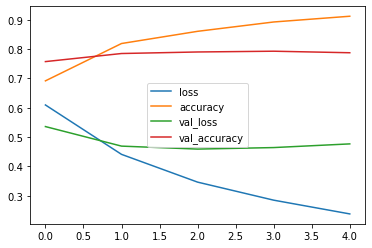

In [63]:
pd.DataFrame(model_1_history.history).plot()

In [59]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

In [99]:
model.predict(['heavy traffic jam due to sinkhole'])

array([[0.99899006]], dtype=float32)

### RNN - LSTM

In [82]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs)            # turn the input text into numbers
x = embedding(x)                       # create an embedding of the numerized numbers

# x = layers.GlobalAveragePooling1D()(x)
# x = layers.LSTM(64)(x)
# x = layers.GRU(64)(x)
# x = layers.Bidirectional(layers.LSTM(64))(x)

x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)

# x = layers.Dense(64, activation="relu")(x) # optional dense layer

outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_2 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

(None, 11, 32)
(None, 32)


In [83]:
# Fit the model
model_2_history = model_2.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1408 - accuracy: 0.9518 - val_loss: 0.7509 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0839 - accuracy: 0.9696 - val_loss: 0.9278 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0660 - accuracy: 0.9742 - val_loss: 1.0161 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0572 - accuracy: 0.9766 - val_loss: 1.1308 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0508 - accuracy: 0.9788 - val_loss: 1.1905 - val_accuracy: 0.7677


In [76]:
model.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 3s 11ms/step - loss: 0.3439 - accuracy: 0.8610 - val_loss: 0.4219 - val_accuracy: 0.8176
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3440 - accuracy: 0.8654 - val_loss: 0.4211 - val_accuracy: 0.8202
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3384 - accuracy: 0.8656 - val_loss: 0.4225 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3394 - accuracy: 0.8685 - val_loss: 0.4226 - val_accuracy: 0.8189
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3315 - accuracy: 0.8669 - val_loss: 0.4233 - val_accuracy: 0.8215
